In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import wikidit

In [2]:
from wikidit.preprocessing import _load_backlog, WP10_LABELS
from wikidit.io import read_labeled

# Train Model

In [3]:
import dill

In [4]:
import os
import os.path
import gzip
import json
import pandas as pd
from joblib import Parallel, delayed

In [5]:
output_dir = "../data/enwiki-labeling_revisions-w_features/"
revisions = read_labeled(output_dir)

# Create a pipeline

In [6]:
from sklearn.model_selection import train_test_split

In [43]:
from wikidit.mw import get_page, Session, get_quality, get_wikiprojects, get_talk_page
session = Session()
page = get_page(session, "Logistic_regression")

In [44]:
get_talk_page("Logistic_regression")

{'pageid': 4819093,
 'ns': 1,
 'title': 'Talk:Logistic regression',
 'revisions': [{'slots': {'main': {'contentmodel': 'wikitext',
     'contentformat': 'text/x-wiki',
     '*': '{{WPStatistics|importance = high|class=C}}\n{{dashboard.wikiedu.org assignment | course = Wikipedia:Wiki_Ed/Amherst_College/STAT495-Advanced-Data-Analysis_(Fall2016) | assignments = [[User:Trant22t|Trant22t]] | reviewers = [[User:Trant22t|Trant22t]] }}\n{{Vital article|class=C|topic=Mathematics|level=5}}\n\n==proposed merge==\nI think this article should be mergedb with [[logit]] [[User:Pdbailey|Pdbailey]] 03:19, 20 April 2006 (UTC)\n\nInteresting question: the [[logit]] link function is the inverse of the [[logistic function]], which also has its own article (that talks about epidemiology, etc.). However, I think the inverse function is only really used in logistic regression, so the merge does make sense. -- [[User:Hike395|hike395]] 14:31, 20 April 2006 (UTC)\n\nNO! This suggestion is totally wrong! logit an

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
import dill
import itertools

from sklearn_ordinal import OrdinalClassifier
from sklearn.preprocessing import FunctionTransformer, Binarizer

count_cols = ['words',
             # infobox as a binary
             'backlog_accuracy',
             'backlog_content',
             'backlog_other',
             'backlog_style',
             'backlog_links']

per_word_cols = [
             'headings_per_word',
             'sub_headings_per_word',
             # links
             'images_per_word',
             'categories_per_word',
             'wikilinks_per_word',
             'external_links_per_word',
             # templates
             'main_templates_per_word',
             'cite_templates_per_word',
             'ref_per_word'    
]

binarized_cols = ['coordinates', 'infoboxes']

response_col = ['wp10']

def create_features(df):
    df = df.copy()
    for c in sqrt_cols:
        df[c] = np.sqrt(df[c])
    for c in binarized_cols:
        df[c] = df[c].astype(bool)
    allcols = list(itertools.chain(per_word_cols, count_cols, binarized_cols))
    return df.loc[:, allcols]



mapper = DataFrameMapper([
    (count_cols, FunctionTransformer(func=np.sqrt)),
    (binarized_cols, Binarizer()),
    (per_word_cols, None)
])

X = revisions
y = revisions['wp10']

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, log_loss, 
                             confusion_matrix)
from sklearn.base import clone

xgb_params = {
              'silent': True,
              'booster': 'gbtree',
              'objective': 'binary:logistic',
              'seed': 1234,
              'n_estimators': 256,
}
xgb_param_grid = {
    'clf__min_child_weight': list(range(1, 11)),
    'clf__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__max_depth': [2, 3, 4, 5, 6, 7, 8]
}

clf = xgb.XGBClassifier(**xgb_params)

rnd_search_pars = {'n_iter': 10, 'n_jobs': 3, 'cv': 5}

scores = {}
best_estimators = {}
best_params = {}
for i, cat in enumerate(list(y.cat.categories)[:-1]):
    print(f"Estimating {cat}")
    idx = y >= cat
    y_cat = (y.loc[idx] > cat).values
    X_cat = X.loc[idx, :]
    X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2,
                                                        stratify=y_cat, random_state=12345)
    clf_cat = clone(clf)
    pipeline = Pipeline([('mapper', mapper), ('clf', clf_cat)])
    rnd_search = RandomizedSearchCV(pipeline, xgb_param_grid, scoring='neg_log_loss',
                                    random_state=1234, refit=True,
                                    **rnd_search_pars)
    rnd_search.fit(X_train, y_train)
    est = rnd_search.best_estimator_
    best_params[cat] = rnd_search.best_params_
    y_pred = est.predict(X_test)
    prob_pred = est.predict_proba(X_test)
    best_estimators[cat] = clone(est)
    scores[cat] = {
        'f1': f1_score(y_test, y_pred),
        'recall_score': recall_score(y_test, y_pred),
        'precision_score': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred),
        'log_loss': log_loss(y_test, prob_pred)
    }


Estimating Stub


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Estimating Start


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Estimating C


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Estimating B


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Estimating GA


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


After finding best parameter values for all models, refit using the entire sample.

In [14]:
models = {}
for i, cat in enumerate(list(y.cat.categories)[:-1]):
    print(f"Re-estimating {cat}")
    idx = y >= cat
    y_cat = (y.loc[idx] > cat).values
    X_cat = X.loc[idx, :]
    clf = clone(best_estimators[cat])
    models[cat] = clf.fit(X_cat, y_cat)

Re-estimating Stub


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Re-estimating Start


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Re-estimating C


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Re-estimating B


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Re-estimating GA


/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [15]:
with open("../models/xgboost-models.pkl", "wb") as f:
    dill.dump(models, f)

In [16]:
with open("../models/xgboost-scoring.pkl", "wb") as f:
    dill.dump(scores, f)

In [17]:
# assessments = pd.read_csv("../data/assessments.csv", comments="#", index_col="class")
# assessments = assessments.loc[['FA', 'GA', 'B', 'C', 'Start', 'Stub'], :]
# assessments['p'] = assessments['articles'] / assessments['articles'].sum()

In [24]:
model.predict_proba(X)[:, 1]

/Users/jrnold/anaconda3/envs/wikidit/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([0.67768264, 0.934595  , 0.7372216 , ..., 0.0249951 , 0.02066803,
       0.00425479], dtype=float32)

# Feature Importances

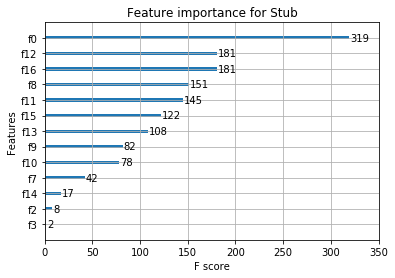

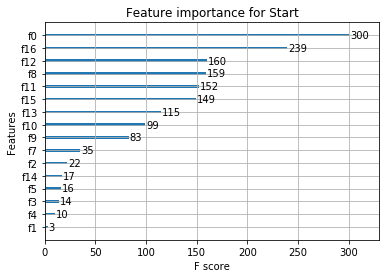

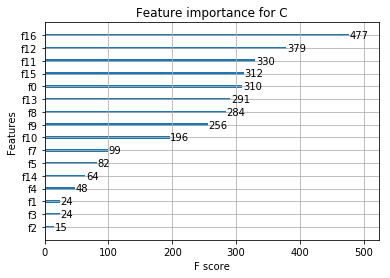

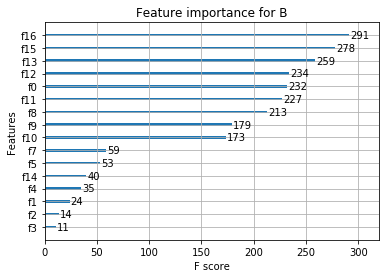

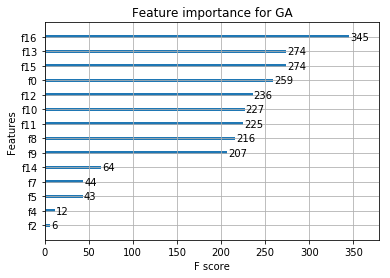

In [22]:
import matplotlib.pyplot as plt
for cat, model in models.items():
    xgb.plot_importance(model.named_steps['clf'])
    plt.title(f"Feature importance for {cat}")
    plt.show()